In [ ]:
pip install yfinance

In [ ]:
pip install pandas_ta

This code is an implementation of a simple trading strategy using Bollinger Bands.

1. **Retrieve Minute-by-Minute Historical Price Data**: The code uses the `yfinance` library to download minute-by-minute historical price data for the specified stock symbol (in this case, 'SPY') for the given date range (from '2023-06-23' to '2023-06-30').

2. **Calculate Bollinger Bands**: Bollinger Bands are a technical indicator used to measure market volatility. The code calculates the middle band as the rolling average of the closing prices over a specified window (30 minutes in this case). It then calculates the upper and lower bands as the middle band plus and minus twice the standard deviation of the closing prices over the same window, respectively.

3. **Implement the Trading Strategy**: The code adds a new column called 'Signal' to the DataFrame to indicate when to buy, sell, or hold the stock. A signal to buy is generated when the closing price crosses below the lower Bollinger Band. A signal to sell is generated when the closing price crosses above the middle Bollinger Band. Additionally, a stop-loss mechanism is implemented: if the price drops by 1% from the buy-in price, it triggers a sell signal.

4. **Backtest the Trading Strategy**: The code simulates the execution of the trading strategy over the given date range. It starts with a starting balance of $100,000. It buys shares whenever a buy signal is generated and sells shares whenever a sell signal is generated. The number of shares bought is determined by dividing the available balance by the closing price at the buy signal.

5. **Calculate Final Portfolio Value and Performance Metrics**: After executing the trading strategy, the code calculates the final portfolio value, which is the sum of the remaining cash balance and the value of the shares held at the last available closing price. It then calculates the total return as the percentage change in the final portfolio value compared to the starting balance. The code also calculates the total number of trades and separates them into winning and losing trades based on the sell prices.

6. **Print Performance Metrics**: Finally, the code prints the performance metrics, including the starting date, final portfolio value, total return, number of trades, number of winning trades, number of losing trades, and the average return per trade.

The strategy is relatively simple and serves as a starting point for more complex trading algorithms. Keep in mind that actual trading involves many additional considerations and risk management strategies that are beyond the scope of this basic implementation.

In [41]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

# Step 1: Retrieve Minute-by-Minute Historical Price Data (using 1-minute granularity)
symbol = 'SPY'
start_date = '2023-06-23'
end_date = '2023-06-30'
data = yf.download(symbol, start=start_date, end=end_date, interval='1m')

# Step 2: Calculate Bollinger Bands
window = 30
std_dev = 2

data['Middle Band'] = data['Close'].rolling(window=window).mean()
data['Upper Band'] = data['Middle Band'] + std_dev * data['Close'].rolling(window=window).std()
data['Lower Band'] = data['Middle Band'] - std_dev * data['Close'].rolling(window=window).std()

stop_loss_percentage = 0.03 # 1% stop loss

# Step 3: Implement the Trading Strategy
data['Signal'] = 0  # 0: Hold, 1: Buy, -1: Sell

for i in range(1, len(data)):
    if data['Close'].iloc[i] < data['Lower Band'].iloc[i]:  # Buy signal
        if data['Close'].iloc[i - 1] >= data['Lower Band'].iloc[i - 1]:
            data.loc[data.index[i], 'Signal'] = 1  # Buy
    elif data['Close'].iloc[i] > data['Middle Band'].iloc[i]:  # Sell signal
        if data['Close'].iloc[i - 1] <= data['Middle Band'].iloc[i - 1]:
            data.loc[data.index[i], 'Signal'] = -1  # Sell
    elif data['Close'].iloc[i] < data['Close'].iloc[i - 1] * (1 - stop_loss_percentage):  # Stop loss
        data.loc[data.index[i], 'Signal'] = -1  # Sell

# Step 4: Backtest the Trading Strategy
starting_balance = 100000
balance = starting_balance
shares = 0
trades = []

for i in range(len(data)):
    if data['Signal'].iloc[i] == 1:  # Buy signal
        shares_to_buy = int(balance / data['Close'].iloc[i])
        shares += shares_to_buy
        balance -= shares_to_buy * data['Close'].iloc[i]
        trades.append(('Buy', data.index[i], data['Close'].iloc[i]))
    elif data['Signal'].iloc[i] == -1 and shares > 0:  # Sell signal
        balance += shares * data['Close'].iloc[i]
        trades.append(('Sell', data.index[i], data['Close'].iloc[i]))
        shares = 0

# Step 5: Calculate Final Portfolio Value and Performance Metrics
final_portfolio_value = balance + shares * data['Close'].iloc[-1]
total_return = (final_portfolio_value - starting_balance) / starting_balance
num_trades = len(trades)

# Calculate winning trades
winning_trades = [(trades[i], trades[i + 1]) for i in range(len(trades) - 1) if trades[i][0] == 'Sell' and trades[i + 1][2] > trades[i][2]]
num_winning_trades = len(winning_trades)
num_losing_trades = num_trades - num_winning_trades

# Calculate average return per trade
average_return_per_trade = total_return / num_winning_trades if num_winning_trades > 0 else 0

# Step 6: Print Performance Metrics
print(f'Starting Date: {start_date}')
print(f'Final Portfolio Value on {end_date}: ${final_portfolio_value:.2f}')
print(f'Total Return: {total_return:.2%}')
print(f'Number of Winning Trades: {num_winning_trades}')
print(f'Average Return per Trade: {average_return_per_trade:.2%}')


[*********************100%***********************]  1 of 1 completed
Starting Date: 2023-06-23
Final Portfolio Value on 2023-06-30: $101406.31
Total Return: 1.41%
Number of Winning Trades: 13
Average Return per Trade: 0.11%


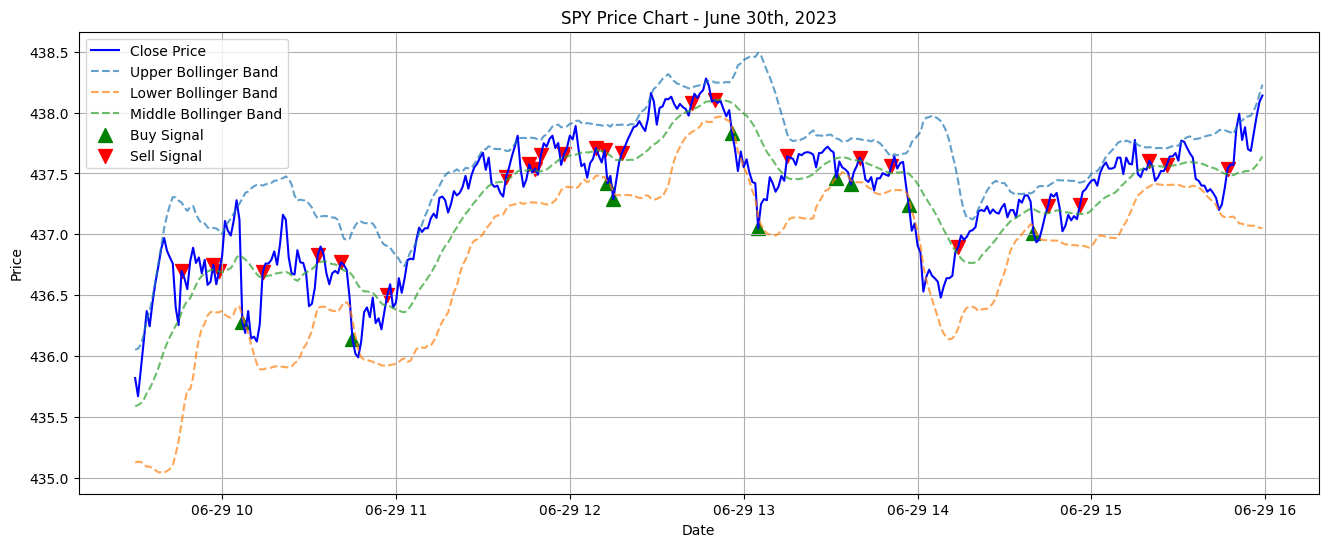

In [22]:
# Step 4: Plot the Data and Signals for June 30th, 2023
start_date_plot = "2023-06-29"
end_date_plot = "2023-06-30"
plt.figure(figsize=(16, 6))
plt.plot(data["Close"].loc[start_date_plot:end_date_plot], label="Close Price", color='b')
plt.plot(data["Upper Band"].loc[start_date_plot:end_date_plot], label="Upper Bollinger Band", linestyle="--", alpha=0.7)
plt.plot(data["Lower Band"].loc[start_date_plot:end_date_plot], label="Lower Bollinger Band", linestyle="--", alpha=0.7)
plt.plot(data["Middle Band"].loc[start_date_plot:end_date_plot], label="Middle Bollinger Band", linestyle="--", alpha=0.7)

# Plot buy and sell signals
buy_signals = data[data["Signal"] == 1].loc[start_date_plot:end_date_plot]
sell_signals = data[data["Signal"] == -1].loc[start_date_plot:end_date_plot]
plt.scatter(buy_signals.index, buy_signals["Close"], marker="^", color="g", label="Buy Signal", s=100)
plt.scatter(sell_signals.index, sell_signals["Close"], marker="v", color="r", label="Sell Signal", s=100)

plt.title(f"{symbol} Price Chart - June 30th, 2023")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid()
plt.show()

